In [1]:
import tensorflow as tf
import io
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from cv2 import imread, IMREAD_GRAYSCALE # IMREAD_GRAYSCALE allow you to load the image as gray scale image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import csv
import gc

2024-11-27 16:01:07.255977: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 16:01:07.288696: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-27 16:01:07.288721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-27 16:01:07.289632: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 16:01:07.295211: I tensorflow/core/platform/cpu_feature_guar

In [2]:
!nvidia-smi

Wed Nov 27 16:01:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:65:00.0 Off |                  N/A |
|  0%   45C    P8              32W / 370W |      3MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
file1 = 'LUNA/HF_comorbidities_train.tfrecords'
file2 = 'LUNA/HF_comorbidities_valid.tfrecords'
file3 = 'LUNA/HF_comorbidities_test.tfrecords'
cormorbidities = ['CAD', 'COPD', 'Asthma', 'CKD', 'Diabetes', 'Hypertension', 'ND', 'Dementia', 'LC', 'RibF', 'Pneumothorax', 'Pneumonia']

In [4]:
gpus = tf.config.list_physical_devices(device_type='GPU')
tf.config.set_visible_devices(devices=gpus[1], device_type='GPU')

In [5]:
raw_dataset = tf.data.TFRecordDataset(file1)
X_train = []
Y_train = []

for raw_record in raw_dataset:
    sub_x = []
    sub_y = []

    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

    Y_train.append(example.features.feature['Label'].int64_list.value[0])
    # temp = np.zeros(5)
    # i = example.features.feature['Race'].int64_list.value[0]
    # temp[i] = 1
    # sub_x.append(temp)
    sub_x.append(example.features.feature['Race'].int64_list.value[0])
    sub_x.append(example.features.feature['Age'].int64_list.value[0])
    sub_x.append(example.features.feature['Gender'].int64_list.value[0])
    # for idx in range(12):
    #     sub_x.append(example.features.feature[cormorbidities[idx]].int64_list.value[0])

    X_train.append(sub_x)
    # Y_train.append(sub_y)

X_train = np.array(X_train)
X_train = X_train.astype(np.int64)
Y_train = np.array(Y_train)
Y_train = Y_train.astype(np.int64)

2024-11-27 16:01:09.261605: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19263 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:b3:00.0, compute capability: 8.6


In [6]:
raw_dataset = tf.data.TFRecordDataset(file2)
X_valid = []
Y_valid = []

for raw_record in raw_dataset:
    sub_x = []
    sub_y = []

    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

    sub_y.append(example.features.feature['Label'].int64_list.value[0])
    # temp = np.zeros(5)
    # i = example.features.feature['Race'].int64_list.value[0]
    # temp[i] = 1
    # sub_x.append(temp)
    sub_x.append(example.features.feature['Race'].int64_list.value[0])
    sub_x.append(example.features.feature['Age'].int64_list.value[0])
    sub_x.append(example.features.feature['Gender'].int64_list.value[0])
    # for idx in range(12):
    #     sub_x.append(example.features.feature[cormorbidities[idx]].int64_list.value[0])
    
    X_valid.append(sub_x)
    Y_valid.append(sub_y)

X_valid = np.array(X_valid)
X_valid = X_valid.astype(np.int64)
Y_valid = np.array(Y_valid)
Y_valid = Y_valid.astype(np.int64)

In [7]:
raw_dataset = tf.data.TFRecordDataset(file3)
X_test = []
Y_test = []

for raw_record in raw_dataset:
    sub_x = []
    sub_y = []

    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

    Y_test.append(example.features.feature['Label'].int64_list.value[0])
    # temp = np.zeros(5)
    # i = example.features.feature['Race'].int64_list.value[0]
    # temp[i] = 1
    # sub_x.append(temp)
    sub_x.append(example.features.feature['Race'].int64_list.value[0])
    sub_x.append(example.features.feature['Age'].int64_list.value[0])
    sub_x.append(example.features.feature['Gender'].int64_list.value[0])
    # for idx in range(12):
    #     sub_x.append(example.features.feature[cormorbidities[idx]].int64_list.value[0])

    X_test.append(sub_x)
    # Y_test.append(sub_y)

X_test = np.array(X_test)
X_test = X_test.astype(np.int64)
Y_test = np.array(Y_test)
Y_test = Y_test.astype(np.int64)

In [8]:
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

(2697, 3) (2697,)
(809, 3) (809, 1)
(347, 3) (347,)


In [9]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [10]:
parameters = {'bootstrap': True,
              'min_samples_leaf': 3,
              'n_estimators': 50, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 6,
              'max_leaf_nodes': None}

In [11]:
RF_model = RandomForestClassifier(**parameters)
RF_model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=3, min_samples_split=10,
                       n_estimators=50)

In [12]:
RF_predictions = RF_model.predict(X_test)
score = accuracy_score(Y_test ,RF_predictions)
print(score)

0.5850144092219021


In [13]:
y_pred_prob = RF_model.predict_proba(X_test)[:, 1] 
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = roc_auc_score(Y_test, y_pred_prob) 
roc_auc

0.6352497485752597

Confusion Matrix:
[[ 56 101]
 [ 43 147]]


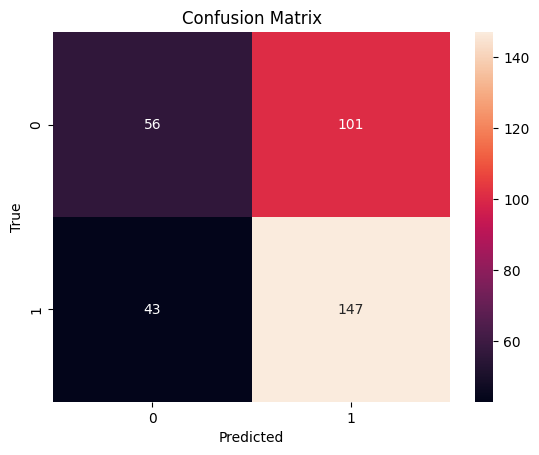

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Compute and display the confusion matrix
cm = confusion_matrix(Y_test, RF_predictions)
print("Confusion Matrix:")
print(cm)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
importances = RF_model.feature_importances_

In [16]:
print(importances)

[0.20579083 0.17926724 0.61494193]


In [17]:
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=3,
    n_redundant=0,
    n_repeated=0,
    n_classes=3,
    random_state=0,
    shuffle=False,
)
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, Y_train)

RandomForestClassifier(random_state=0)

In [18]:
forest_predictions = forest.predict(X_test)
score = accuracy_score(Y_test ,forest_predictions)
print(score)

0.6023054755043228


In [33]:
y_pred_prob = forest.predict_proba(X_test)[:, 1] 
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = roc_auc_score(Y_test, y_pred_prob) 
print(roc_auc)

0.6386356017432115


In [35]:
list1=np.round(y_pred_prob)
ans1=[]
for i in range(len(list1)):
    if list1[i]==Y_test[i]:
        ans1.append(i)
print(ans1)

[0, 3, 4, 5, 6, 8, 10, 13, 16, 18, 23, 24, 26, 27, 29, 30, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 52, 53, 55, 56, 59, 60, 61, 62, 63, 65, 68, 70, 74, 76, 77, 79, 80, 83, 86, 88, 89, 90, 92, 93, 95, 96, 98, 100, 101, 102, 104, 105, 106, 108, 109, 110, 113, 114, 115, 117, 119, 120, 126, 128, 129, 134, 136, 137, 139, 140, 143, 145, 149, 151, 153, 154, 155, 157, 158, 159, 160, 161, 162, 165, 166, 168, 169, 171, 173, 175, 179, 180, 181, 182, 184, 185, 188, 189, 190, 192, 193, 194, 196, 197, 201, 202, 205, 207, 208, 210, 211, 212, 213, 214, 216, 217, 218, 219, 220, 222, 227, 230, 232, 233, 234, 235, 236, 237, 238, 239, 241, 242, 243, 244, 245, 246, 247, 248, 250, 252, 255, 257, 259, 260, 261, 265, 268, 269, 272, 273, 274, 275, 276, 277, 279, 280, 281, 283, 284, 288, 289, 290, 291, 292, 294, 295, 297, 298, 300, 302, 303, 304, 305, 307, 308, 311, 312, 313, 314, 315, 316, 317, 318, 322, 324, 325, 326, 327, 328, 329, 330, 332, 333, 334, 336, 339, 340, 342, 343, 344, 345, 346]


In [22]:
from Utils import * 

fpr, tpr, threshes =metrics.roc_curve(Y_test, y_pred_prob)
best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)
metrics.auc(fpr, tpr)

0.6386356017432115

In [24]:
# from joblib import dump, load

# dump(forest, 'random_forest_model_demographics.joblib')

# # loaded_model = load('random_forest_model.joblib')

Confusion Matrix:
[[ 63  94]
 [ 44 146]]


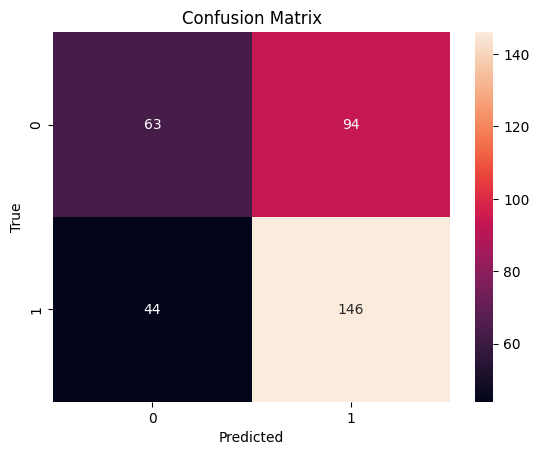

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Compute and display the confusion matrix
cm = confusion_matrix(Y_test, forest_predictions)
print("Confusion Matrix:")
print(cm)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [26]:
importances = forest.feature_importances_

In [27]:
print(importances)

[0.23459596 0.16810181 0.59730223]


In [28]:
forest_test = forest.predict_proba(X_test)

In [29]:
positive_class_probabilities = forest_test[:, 1]

In [30]:
positive_class_probabilities

array([0.53939106, 0.63686575, 0.73512292, 0.76726453, 0.76726453,
       0.47956662, 0.63686575, 0.4431031 , 0.74950396, 0.47956662,
       0.79844517, 0.76726453, 0.45168593, 0.76726453, 0.76726453,
       0.4431031 , 0.41557647, 0.48438205, 0.76726453, 0.4431031 ,
       0.53939106, 0.2398374 , 0.60304258, 0.56625578, 0.35546927,
       0.73512292, 0.76726453, 0.73512292, 0.56963201, 0.62099558,
       0.76726453, 0.76726453, 0.73512292, 0.53939106, 0.35546927,
       0.73512292, 0.4431031 , 0.90061417, 0.48438205, 0.76726453,
       0.53939106, 0.90061417, 0.4431031 , 0.41557647, 0.60304258,
       0.69670208, 0.4431031 , 0.63686575, 0.62099558, 0.2398374 ,
       0.53939106, 0.63686575, 0.63686575, 0.47956662, 0.4431031 ,
       0.76726453, 0.35546927, 0.4431031 , 0.63686575, 0.90061417,
       0.73512292, 0.41557647, 0.76726453, 0.74950396, 0.76726453,
       1.        , 0.47956662, 0.53939106, 0.4431031 , 0.63686575,
       0.53939106, 0.63686575, 0.76726453, 0.63686575, 0.45168

In [31]:
# with tf.device('/cpu:0'):

#     filename = "LUNA/HF_comorbidities_test.tfrecords"
    
#     raw_dataset = tf.data.TFRecordDataset(filename)
#     X_train = []
#     Y_train = []
#     i=0
#     for raw_record in raw_dataset:
#         sub_y = []
    
#         example = tf.train.Example()
#         example.ParseFromString(raw_record.numpy())
    
#         nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)
#         # img_np = cv.imdecode(nparr, cv.IMREAD_GRAYSCALE)
#         img_np = cv.imdecode(nparr, cv.IMREAD_COLOR)
#         # img_np = cv.imdecode(nparr, cv.COLOR_BGR2RGB)
#         X_train.append(img_np)
#         # Y_train.append(sub_y)
    
#         # img_np = cv.imdecode(nparr, cv.IMREAD_GRAYSCALE)
#         # plt.imshow(img_np, cmap='gray')
#         # plt.show()
    
#     X_train = np.array(X_train)
#     # Y_train = np.array(Y_train)
#     X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],-1)
#     # Y_train = Y_train.astype(np.float64)
#     # print(Y_train.shape)

In [32]:
# X_train.shape